In [58]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os, sys
from pyproj import CRS, Transformer
import fiona

import warnings
warnings.filterwarnings('ignore')

from geopy.extra.rate_limiter import RateLimiter

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

import matplotlib.pyplot as plt
import matplotlib as mpl
from math import floor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

#Navigate to folder where data is stored in the drive.
%cd /content/drive/MyDrive/

dirname = '/content/drive/MyDrive/'

Mounted at /content/drive
/content/drive/MyDrive


In [4]:
fname = 'NSPublic_Housing_2024.csv'

In [53]:
def find_loc(file_name):

    #Test the geocoder
    locator = Nominatim(user_agent="http")
    location = locator.geocode("115 Walker Ave, Summerside, PEI")
    print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))


    geocode = RateLimiter(locator.geocode, min_delay_seconds=1) #https://operations.osmfoundation.org/policies/nominatim/

    #Get Toronto address
    lat = []
    lon = []
    #Read in the downloaded list of parking ticket addresses (first 100)
    add_csv = pd.read_csv(file_name,sep=',')[0::10]
    add_csv = add_csv.drop_duplicates(subset='Civic Address', keep="last")
    add_csv = add_csv[add_csv['Civic Address'] != '27 Castle Loma Dr']
    add_csv = add_csv[add_csv['Civic Address'] != '39 Castle Loma Dr']
    add_csv = add_csv[add_csv['Civic Address'] != '2693 Morse Rd']
    print('Number of addresses: %s'%(len(add_csv)))
    #The file needs to be in the same folder as the Python script
    count = 1
    #Loop through the addresses
    for ad,Town in zip(list(add_csv['Civic Address']),list(add_csv['Community'])): #location2 is the address column in the ticket data
        location = locator.geocode(ad+"," +Town+", Nova Scotia", timeout=200)
        try:
            lat.append(location.latitude)
            lon.append(location.longitude)
            #print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))
        except (AttributeError,TimeoutError,GeocoderTimedOut):
            lat.append('NA')
            lon.append('NA')
        count += 1

    add_csv['latitude'] = lat
    add_csv['longitude'] = lon

    #Output the found latitude and longitude to a new file
    return add_csv

In [55]:
df_points = find_loc(fname)

Latitude = 46.4154243, Longitude = -63.7828318
Number of addresses: 294


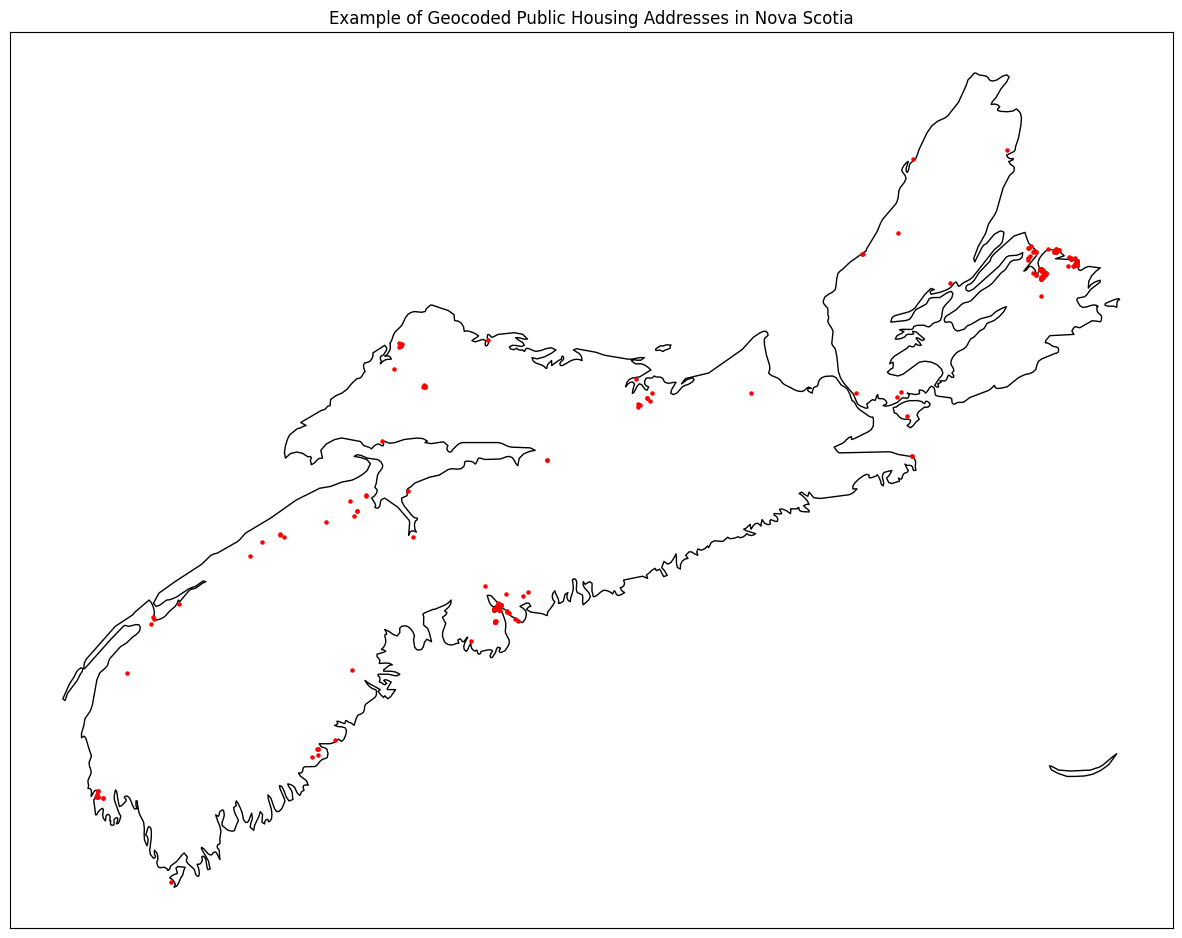

In [59]:
df_points = df_points[df_points['latitude'] != 'NA']

nova_scotia = gpd.read_file('halifax.shp')

fig, ax = plt.subplots(figsize=(15, 15))

ax.set_title('Example of Geocoded Public Housing Addresses in Nova Scotia')
ax.set_yticks([])
ax.set_xticks([])
nova_scotia.plot(ax=ax,facecolor="none", edgecolor="black")
df_points = gpd.GeoDataFrame(df_points, geometry=gpd.points_from_xy(df_points['longitude'], df_points['latitude']), crs='EPSG:4326')
df_points.plot(ax=ax, color='red', markersize=5);
plt.show();